# Autocorrelation structure of tree mortality

### Load data

In [1]:
import xarray as xr
import numpy as np
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature

if 'notebook' in os.getcwd():
    os.chdir("..")

import util

ds = xr.Dataset.from_dataframe(util.preisler.make_preisler_dataframe().reset_index().set_index(["latitude", "longitude", "year"]))

/home/jovyan/ForestLST/util/__init__.py:12: UserWarning: PyTorch not found! Module util.training will not be loaded.
  warnings.warn("PyTorch not found! Module util.training will not be loaded.")


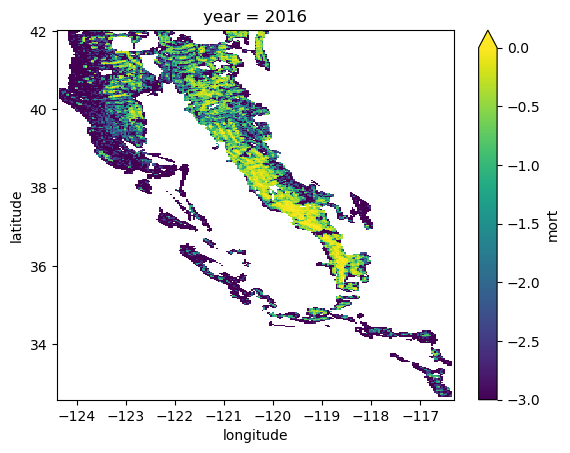

In [2]:
eps = 1e-3
log_img = np.log10(ds.mort.sel(year=2016) + eps)
log_img.plot(vmin=-3, vmax=0, cmap="viridis")

### Local indicators of spatial autocorrelation (LISA)

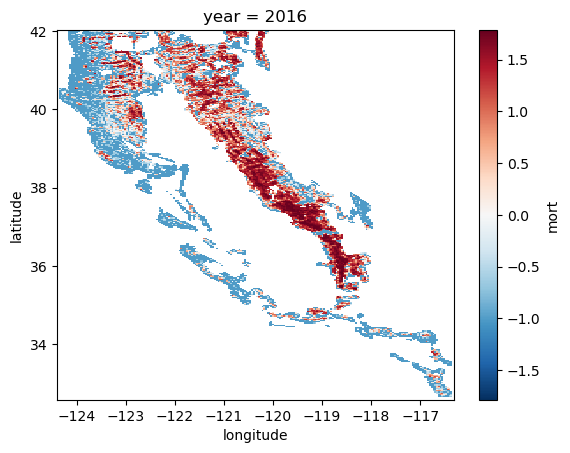

In [3]:
Z = (log_img - log_img.mean()) / log_img.std()
Z.plot()

The formula for the test statistic is $I_i = z_i \Sigma_j w_{ij}z_{ij}$.

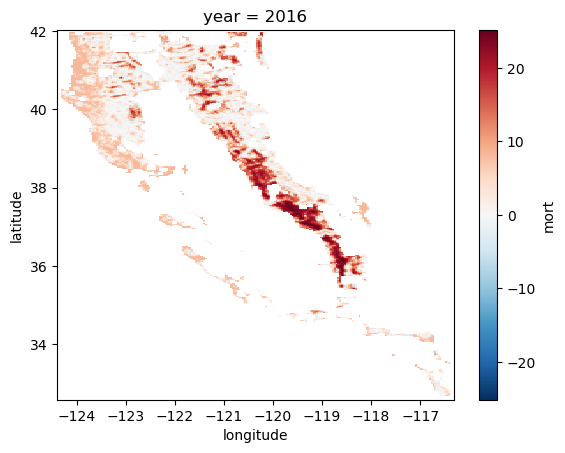

In [4]:
from scipy.ndimage import convolve

kernel = np.array([
    [1, 1, 1],
    [1, 0, 1], # dont include central pixel
    [1, 1, 1]
])

conv2d = lambda x: convolve(x, kernel, mode="constant", cval=0)

localI = xr.apply_ufunc(conv2d, Z) * Z
localI.plot()

Calculate the null distribution of Moran's I by randomly assorting the above distribution of Z-scores in space.

In [5]:
Z_dist = Z.values.flatten()[np.where(~np.isnan(Z.values.flatten()))]

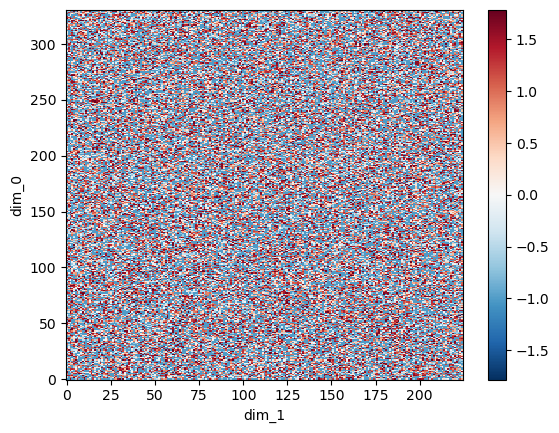

In [6]:
Z_null = np.random.choice(Z_dist, size=Z.values.flatten().shape[0]).reshape(Z.shape)
xr.DataArray(Z_null).plot()

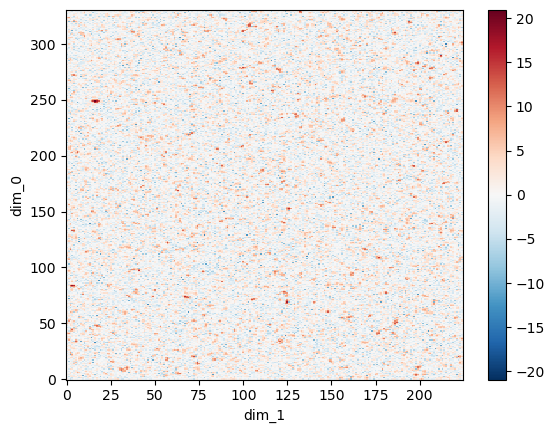

In [7]:
localI_null = xr.apply_ufunc(conv2d, Z_null) * Z_null
xr.DataArray(localI_null).plot()

In [8]:
sig_localI = np.percentile(np.abs(localI_null.flatten()), 99)

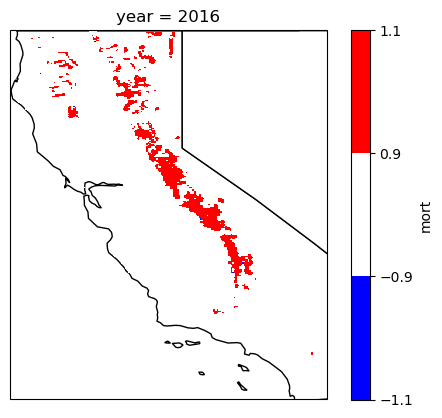

In [9]:
from matplotlib import colors
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

mercator_proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=mercator_proj))

c_map = colors.ListedColormap(['blue', 'white', 'red'])
bounds = [-1.1, -0.9, 0.9, 1.1]
norm = colors.BoundaryNorm(bounds, c_map.N)

# -1 = significant negative correlation, 0 = no correlation, 1 = significnat positive correlation
test_result = ((np.abs(localI) > sig_localI) * np.sign(localI)).plot(cmap=c_map, norm=norm, ax=ax)



# Add state borders
state_borders = cfeature.NaturalEarthFeature(
    category='cultural', 
    name='admin_1_states_provinces_lakes', 
    scale='50m', facecolor='#FFFFFF'
)

ax.add_feature(state_borders, edgecolor="black", zorder=0)